<a href="https://colab.research.google.com/github/vaibhavsundharam/Face-Anti-Spoofing/blob/master/Face_Anti_Spoofing_Replay_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Initializations

In [ ]:
import torch
import sys
import os
from __future__ import print_function, division
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
import cv2
import re
import pandas as pd
import numpy as np
import cv2
import PIL
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode


In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Set device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
prefix = '/content/gdrive/My Drive/'
# modify "customized_path_to_your_project" 
customized_path_to_your_project = '/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/' # enter the main directory (change location as required)
sys_path = os.path.join(prefix, customized_path_to_your_project)
sys.path.append(sys_path)
print(f"sys_path: {sys_path}")

sys_path: /content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/


In [ ]:
# reading the text file with real and fake faces
data_directory=sys_path+"Data/Replay Attack"
print(f"Data directory location:{data_directory}")

Data directory location:/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/Data/Replay Attack


#Data Preprocessing

In [ ]:
# combining real and fake faces file for training and dev

train_real_txt_file=data_directory+"/train_real.txt"  
train_attack_txt_file=data_directory+"/train_attack.txt"

train_real_images_loc=data_directory+"/train_real/" 
train_attack_images_loc=data_directory+"/train_attack/"

train_data=[(train_real_txt_file, train_real_images_loc, 1), (train_attack_txt_file, train_attack_images_loc, 0 )] # encoding the class

#train_img_list=list() # list containing the location of images 

with open("train_combined.txt", "w") as out:
  for a,b,c in train_data:
    with open(a, "r") as file:
      for line in file:        
        line=line.rstrip()
        out.write(b + "/" +line + "/" + str(c) + "\n")
        
read_file_train=pd.read_csv (r'/content/train_combined.txt', header = None)
read_file_train.columns = ["image"]
read_file_train.to_csv (r"train_combined.csv", index=None)       
print(f"Total number of examples for training: {len(read_file_train)}")

Total number of examples for training: 2950


In [ ]:
# combining real and fake faces file for dev and converting it to a csv 

dev_real_txt_file=data_directory+"/dev_real.txt"
dev_attack_txt_file=data_directory+"/dev_attack.txt"

dev_real_images_loc=data_directory+"/dev_real/" 
dev_attack_images_loc=data_directory+"/dev_attack/"

dev_data=[(dev_real_txt_file, dev_real_images_loc, 1),(dev_attack_txt_file, dev_attack_images_loc, 0)]

#dev_img_list=list() # list containing the location of images 

with open("dev_combined.txt", "w") as out:
  for a,b,c in dev_data:
    with open(a, "r") as file:
      for line in file:        
        line=line.rstrip()
        out.write(b + "/" +line + "/" + str(c) + "\n")
        
read_file_dev = pd.read_csv (r'/content/dev_combined.txt', header = None)
read_file_dev.columns = ["image"]
read_file_dev.to_csv (r"dev_combined.csv", index=None)

print(f"Total number of examples for dev set: {len(read_file_dev)}")


Total number of examples for dev set: 2937


In [ ]:
# combining real and fake faces file for testing and converting it to a csv 

test_real_txt_file=data_directory+"/test_real.txt"
test_attack_txt_file=data_directory+"/test_attack.txt"

test_real_images_loc=data_directory+"/test_real/" 
test_attack_images_loc=data_directory+"/test_attack/"

test_data=[(test_real_txt_file, test_real_images_loc, 1),(test_attack_txt_file, test_attack_images_loc, 0)]

#test_img_list=list() # list containing the location of images 

with open("test_combined.txt", "w") as out:
  for a,b,c in test_data:
    with open(a, "r") as file:
      for line in file:        
        line=line.rstrip()
        out.write(b + "/" +line + "/" + str(c) + "\n")
        
read_file_test = pd.read_csv (r'/content/test_combined.txt', header = None)
read_file_test.columns = ["image"]
read_file_test.to_csv (r"test_combined.csv", index=None)

print(f"Total number of examples for test set: {len(read_file_test)}")


Total number of examples for test set: 3888


# Data loaders and data augmentation

In [ ]:
# custom class to explore dataset
class face_dataset(Dataset):
  def __init__(self, data_split_csv_loc, transform=None): 
    self.data_split_csv_loc=pd.read_csv(data_split_csv_loc)    
    self.transform=transform    
    

  def __len__(self):  # returns the length of the data set
     return len(self.data_split_csv_loc)

  def __getitem__(self, idx):    
    img_loc=self.data_split_csv_loc.iloc[idx,0][:-2]           
    img_class=int(self.data_split_csv_loc.iloc[idx,0][-1])
    img_transform=self.transform(Image.open(img_loc))    
    
    return  img_transform,   img_class  #---> returned values are a touple and image class 

In [ ]:
# LBP+sharpen for transforms 

from skimage.feature import local_binary_pattern

class to_LBP():
  '''class to calculate LBP'''

  def __init__(self, n_points_radius, method):
    self.n_points=n_points_radius
    self.method=method       
    self.channels=len(self.n_points) 
    self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  
  def  __call__(self, sample):       
    sample = np.array(sample)
    w, h=sample.shape[0], sample.shape[1]    
    temp=np.zeros((self.channels, w, h))   

    image = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY) # convert to grayscale
    image=cv2.normalize( image, None, 0, 255, cv2.NORM_MINMAX) # normalization
    image=cv2.filter2D(image, -1, self.kernel) # high pass filtering

    for idx, values in enumerate(self.n_points):             
      lbp=local_binary_pattern(image, values[0], values[1], self.method)              
      temp[idx]=lbp      
    return (temp,  image)

In [ ]:
# Here we create two seperate instances of the face_dataset class. One will hold the data set for training and the other will hold data for dev

lbp_maps=lbp_maps=[(3,3),(4,1), (4,2), (8,1), (8,2), (8,3), (8,5), (16,2), (16,3), (16,5)]
num_input_channels=len(lbp_maps)
print(f"Number of input channels: {num_input_channels}")

train_dataset=face_dataset(data_split_csv_loc="/content/train_combined.csv", transform=transforms.Compose([transforms.Resize((150, 150)),  transforms.RandomHorizontalFlip(),
                                                                                                          to_LBP(n_points_radius=lbp_maps, method="uniform")]))
dev_dataset=face_dataset(data_split_csv_loc="/content/dev_combined.csv", transform= transforms.Compose([transforms.Resize((150 , 150)), 
                                                                                                      to_LBP(n_points_radius=lbp_maps, method="uniform")]))
test_dataset=face_dataset(data_split_csv_loc="/content/test_combined.csv", transform= transforms.Compose([transforms.Resize((150, 150)), 
                                                                                                           to_LBP(n_points_radius=lbp_maps, method="uniform")]))


len_train_dataset, len_dev_dataset, len_test_dataset, =len(train_dataset), len(dev_dataset), len(test_dataset) 
print(f"Total number of elements in training dataset: {len_train_dataset}")
print(f"Total number of elements in dev dataset: {len_dev_dataset}")
print(f"Total number of elements in test dataset: {len_test_dataset}")

Number of input channels: 10
Total number of elements in training dataset: 2950
Total number of elements in dev dataset: 2937
Total number of elements in test dataset: 3888


#Data Exploration

In [ ]:
# function for plotting LBP 

def plot( touple):   
  fig, axs = plt.subplots(touple[0].shape[0], touple[0].shape[1]+1, figsize=(25,25))  
 
  
  """plotting the images on which lbp is calculated """
  for img in range(touple[1].shape[0]):
    
    axs[img, 0 ].imshow(touple[1][img], cmap = "gray")

  """plotting the LBP of the image """     
  for example in range(touple[0].shape[0]):
    
    for image in range(touple[0].shape[1]):
      
      axs[example, image+1].imshow(touple[0][example][image], cmap= "gray")

In [ ]:
plot_loader=DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=8) 

for batch, label  in plot_loader:  # getting one batch for visualizing data  
  print(batch[0].shape)
  break

torch.Size([8, 10, 150, 150])


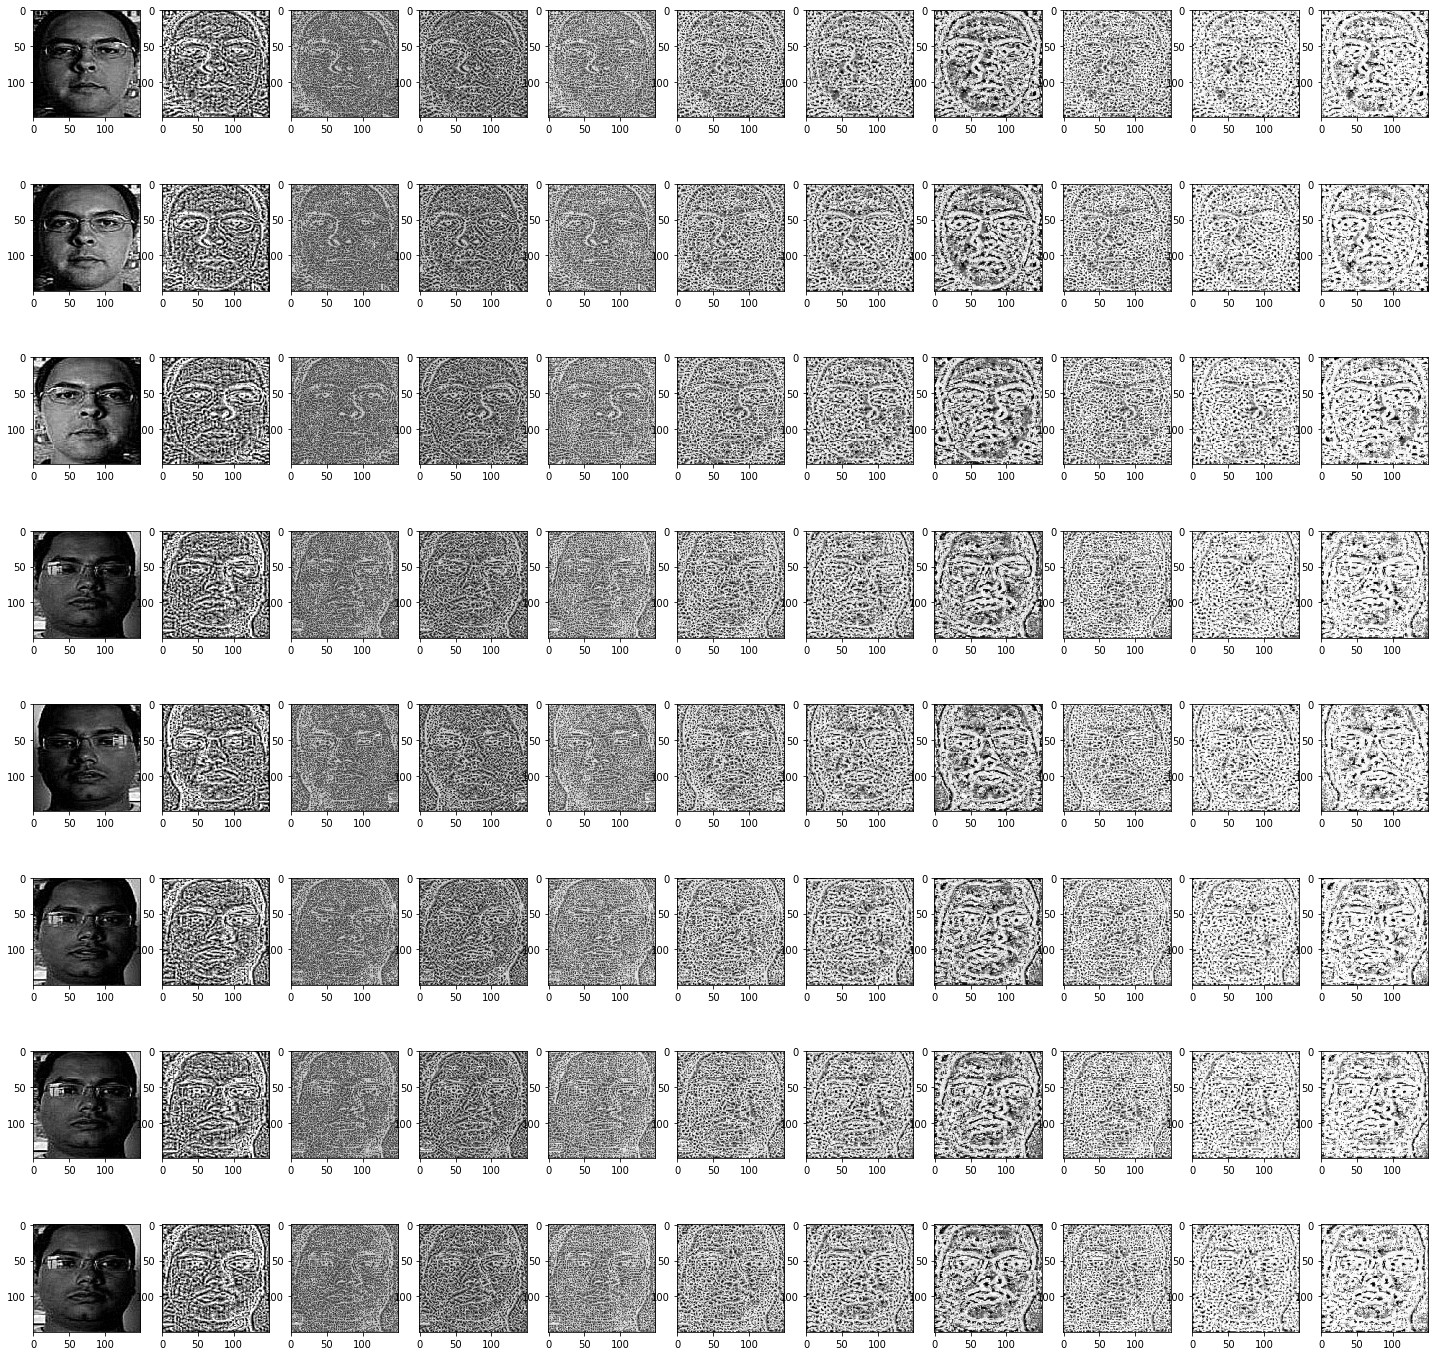

In [ ]:
plot(batch)

#Helper functions

In [ ]:
# get true positives, true negatives,  false positives and false negatives

def confusion_matrix(ys, y_preds):
  ys=ys.detach()
  ys=ys.to("cpu")
  y_preds=y_preds.detach()
  y_preds=y_preds.to("cpu")

  ys=np.asarray(ys)
  y_preds=np.asarray(y_preds)  

  tp=np.sum((y_preds == 1) & (ys == 1))
  tn=np.sum((y_preds == 0) & (ys == 0))
  fp=np.sum((y_preds == 1) & (ys == 0))
  fn=np.sum((y_preds == 0) & (ys == 1))

  print(f"tp:{tp}, tn: {tn}, fp:{fp}, fn: {fn}") 

  return tp, tn, fp, fn

In [ ]:
# def confusion matrix test

a=torch.Tensor([1,1,1,0,0,0])
b=torch.Tensor([0,1,0,1,0,1])

TP, TN, FP, FN=confusion_matrix(a, b)
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
print("Answer:TP: 1, TN: 1, FP: 2, FN: 2")

tp:1, tn: 1, fp:2, fn: 2
TP: 1, TN: 1, FP: 2, FN: 2
Answer:TP: 1, TN: 1, FP: 2, FN: 2


In [ ]:
# HTER claculation for test and validation
def HTER(model, loss_criterion, loader):
  Ys=list()
  Y_preds=list()
  Loss_total=0    
  total_step=len(loader)
  
  for touple, label in loader:
    batch=touple[0]
    batch=batch.to(device=device, dtype=torch.float)
    label=label.to(device=device, dtype=torch.long)
    Ys.append(label) 
    Y_pred=model(batch)       
    Y_preds.append(torch.argmax(Y_pred, dim=1))    
    Loss=loss_criterion(Y_pred,label)    
    Loss_total += Loss.item() 
    
    
  Y= torch.cat(Ys, dim=0)
  Y_pred=torch.cat(Y_preds, dim=0)
  tp, tn, fp, fn =confusion_matrix(Y, Y_pred)
  hter=1-(0.5*((tp/(tp+fn))+(tn/(tn+fp))))
  
  return (hter*100, Loss_total/total_step)

In [ ]:
# solver function for Neural Network

def Solver_NN(model, train_loader, dev_loader, optim, criterion, device,  scheduler, print_every=10, epoch=51, lr=1e-1):
  print("Solver Initiated")  
  model=model.to(device) # sending model to GPU
  print("Model successfully sent to the GPU\n")

  print_every=print_every
  total_step = len(train_loader)
  counter=0

  for e in range(epoch):
    running_loss = 0.0    
    epoch_loss=0.0
    for i, (x,y) in enumerate(train_loader):
      optim.zero_grad()

      X=x[0]      
      X=X.to(device=device, dtype=torch.float)
      y=y.to(device=device, dtype=torch.long)
     
      #forward pass########
      y_pred=model(X)                  
      loss=criterion(y_pred, y)          
      ####################
      
      # backward pass#######     
      loss.backward()
      optim.step()
      ####################      
      running_loss += loss.item()
      epoch_loss+=running_loss
      if (i+1) % print_every == 0:       # print every 10
        print ("Epoch [{}/{}], Step [{}/{}] Loss: {}".format(counter+1, epoch, i+1, total_step, running_loss/print_every))
        running_loss = 0.0
    counter+=1     

    with torch.no_grad():            
      train_hter, train_loss=HTER(model=model, loss_criterion=criterion, loader=train_loader)    
      dev_hter, dev_loss=HTER(model=model, loss_criterion=criterion, loader=dev_loader)           
      print(f"Train loss in epoch {e+1} is {(train_loss)} and Train HTER in epoch {e+1}: {train_hter}") 
      print(f"Dev loss in epoch {e+1} is {(dev_loss)} and Dev HTER in epoch {e+1}: {dev_hter}")  
      scheduler.step(dev_loss)    
    torch.save(model.state_dict(), sys_path + 'Codes/Replay Attack/weights_replay_attack_1FPS/weights/Resnet_Replay_attack_'+ str(e+1) + "_" + str(np.floor(dev_hter))+'.pkl') 
    print("Model saved successfully!\n")
    
  return model

In [ ]:
##DO NOT CHANGE##
class Resnet(nn.Module):
  def __init__(self, inp_channels, model):
    super().__init__()
    self.inp_channels=inp_channels
    self.first=nn.Sequential(nn.Conv2d(self.inp_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), nn.ReLU(inplace=True))
    self.cnn=nn.Sequential(*(list(model.children())[1:5]), nn.AdaptiveAvgPool2d(output_size=(1, 1)), nn.Flatten())    
    self.fc=nn.Sequential( nn.Linear(256, 128), nn.Dropout(p=0.5), nn.Linear(128, 64), nn.Dropout(p=0.5), nn.Linear(64, 2))     

  def forward(self, x):  

    x=self.first(x)
    #print(f"1: {x.shape}")

    x=self.cnn(x)
    #print(f"2: {x.shape}")

    x=self.fc(x)
    #print(f"3 {x.shape}")

    return x

# Training

In [ ]:
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model= Resnet(num_input_channels, resnet )
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Resnet(
  (first): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace=True)
  )
  (cnn): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [ ]:
#criterion and optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr=0.001
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion 
optim=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.1) # optimizer 
scheduler =  ReduceLROnPlateau(optim, mode='min', factor=0.1, patience= 2, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

In [ ]:
# GPU Access and model parameters
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print("Running on Cuda")
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable parameters:",params)

Running on Cuda
Learnable parameters: 288578


In [ ]:
# loading training and validation data for the neural network
train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8) 
dev_loader=DataLoader(dev_dataset, batch_size=256, shuffle=True, num_workers=8) 

In [ ]:
model=Solver_NN(model, train_loader, dev_loader, optim,criterion, device, scheduler, print_every=5, epoch=51, lr=lr)

Solver Initiated
Model successfully sent to the GPU

Epoch [1/51], Step [5/12] Loss: 0.5999699831008911
Epoch [1/51], Step [10/12] Loss: 0.5650876879692077
tp:0, tn: 2233, fp:0, fn: 717
tp:0, tn: 2217, fp:0, fn: 720
Train loss in epoch 1 is 0.5562233154972395 and Train HTER in epoch 1: 50.0
Dev loss in epoch 1 is 0.5557427008946737 and Dev HTER in epoch 1: 50.0
Model saved successfully!

Epoch [2/51], Step [5/12] Loss: 0.5533200860023498
Epoch [2/51], Step [10/12] Loss: 0.5387262582778931
tp:0, tn: 2233, fp:0, fn: 717
tp:0, tn: 2217, fp:0, fn: 720
Train loss in epoch 2 is 0.5301139950752258 and Train HTER in epoch 2: 50.0
Dev loss in epoch 2 is 0.5367821902036667 and Dev HTER in epoch 2: 50.0
Model saved successfully!

Epoch [3/51], Step [5/12] Loss: 0.5154520034790039
Epoch [3/51], Step [10/12] Loss: 0.5149602055549621
tp:0, tn: 2233, fp:0, fn: 717
tp:0, tn: 2217, fp:0, fn: 720
Train loss in epoch 3 is 0.49674876282612485 and Train HTER in epoch 3: 50.0
Dev loss in epoch 3 is 0.499247

#Testing

In [ ]:
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model= Resnet(num_input_channels, resnet )
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Resnet(
  (first): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace=True)
  )
  (cnn): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [ ]:
model.load_state_dict(torch.load("/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/Codes/Replay Attack/weights_replay_attack_1FPS/batch size =256, lr = 0.001, weight decay = 0.1, best HTER 4 epoch 12/Resnet_Replay_attack_12_4.0.pkl"))

<All keys matched successfully>

In [ ]:
test_loader=DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=8) 
len_test_dataset= len(test_dataset)

print(f"Total number of elements in test dataset: {len_test_dataset}")

Total number of elements in test dataset: 3888


In [ ]:
model=model.to(device)
with torch.no_grad():      
      test_hter, test_loss=HTER(model=model, loss_criterion=criterion, loader=test_loader)
      print(f"Test loss  is {(test_loss/len_test_dataset)}")
      print(f'Test HTER: {test_hter}\n')

tp:868, tn: 2827, fp:111, fn: 82
Test loss  is 3.237370940580688e-05
Test HTER: 6.20482963706066

